# Trabajo Práctico Final - Análisis de Series de Tiempo

**Curso:** Análisis de Series de Tiempo (01MA2025)

**Docente** Camilo Argoty

**Alumnos** Fabian Sarmiento, Juan Ignacio Ribet

**Dataset:** Estimación de Población Mensual de EE.UU. (`uspopulation.csv`)

**Objetivo:** Analizar la serie temporal de la población estimada de Estados Unidos, construir y comparar al menos tres modelos de pronóstico diferentes, y responder a una pregunta de investigación basada en los resultados.


## Contenido:
1. Importación de Librerías
2. Carga y Preparación de Datos
3. Análisis Exploratorio
4. Análisis de Componentes de la Serie
5. Modelado y Pronóstico
6. Evaluación y Comparación
7. Conclusiones

## 1. Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para las gráficas
sns.set_style("whitegrid")  # Usando el estilo de seaborn directamente
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

### Importación de Componentes Estadísticos

Importamos los componentes específicos de statsmodels necesarios para el análisis de series temporales:

- Componentes para pruebas de estacionariedad
- Funciones para descomposición de series
- Modelos ARIMA, SARIMA y sus herramientas de diagnóstico

In [2]:
# Componentes de statsmodels
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Para pruebas de estacionariedad
from statsmodels.tsa.stattools import adfuller, kpss

## 2. Carga y Preparación de Datos

### Descripción del Dataset

El archivo `uspopulation.csv` contiene datos mensuales de la población estimada de Estados Unidos:

- **Período**: Enero 2011 - Diciembre 2018
- **Frecuencia**: Mensual
- **Variables**:
  - `DATE`: Fecha de la estimación
  - `PopEst`: Estimación de la población (en miles)

### Proceso de Carga
Cargaremos los datos asegurándonos de:
1. Interpretar correctamente las fechas
2. Establecer la columna de fecha como índice
3. Verificar la estructura y calidad de los datos

In [9]:
# Carga del dataset
df_ts = pd.read_csv("uspopulation.csv", parse_dates=["DATE"], index_col='DATE')
df_ts.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


In [6]:
print("\nInformación del dataset:")
df_ts.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2011-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PopEst  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


In [7]:
print("\nEstadísticas descriptivas:")
df_ts.describe()


Estadísticas descriptivas:


,PopEst
count,96.000000
mean,319826.760417
std,5159.523729
min,311037.000000
25%,315419.000000
50%,319919.500000
75%,324395.250000
max,328393.000000


## 3. Análisis de Calidad de Datos

Realizaremos las siguientes verificaciones:
- Presencia de valores faltantes
- Consistencia en la frecuencia temporal
- Detección de valores atípicos
- Verificación del tipo de datos

In [11]:
# Verificación de valores faltantes
print("Valores faltantes por columna:")
print(df_ts.isnull().sum())

# Verificación de la frecuencia temporal
print("\nFrecuencia temporal:")
print("Primer fecha:", df_ts.index.min())
print("Última fecha:", df_ts.index.max())
print("Número total de observaciones:", len(df_ts))

# Verificación de valores atípicos usando el método IQR
Q1 = df_ts['PopEst'].quantile(0.25)
Q3 = df_ts['PopEst'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_ts[(df_ts['PopEst'] < (Q1 - 1.5 * IQR)) | (df_ts['PopEst'] > (Q3 + 1.5 * IQR))]

print("\nNúmero de valores atípicos detectados:", len(outliers))

Valores faltantes por columna:
PopEst    0
dtype: int64

Frecuencia temporal:
Primer fecha: 2011-01-01 00:00:00
Última fecha: 2018-12-01 00:00:00
Número total de observaciones: 96

Número de valores atípicos detectados: 0


## 4. Visualización Inicial de la Serie Temporal

En esta sección realizaremos una exploración visual de nuestra serie temporal para identificar:
- Tendencia general de la población
- Posibles patrones estacionales
- Comportamiento de la serie a lo largo del tiempo
- Posibles anomalías o cambios estructurales

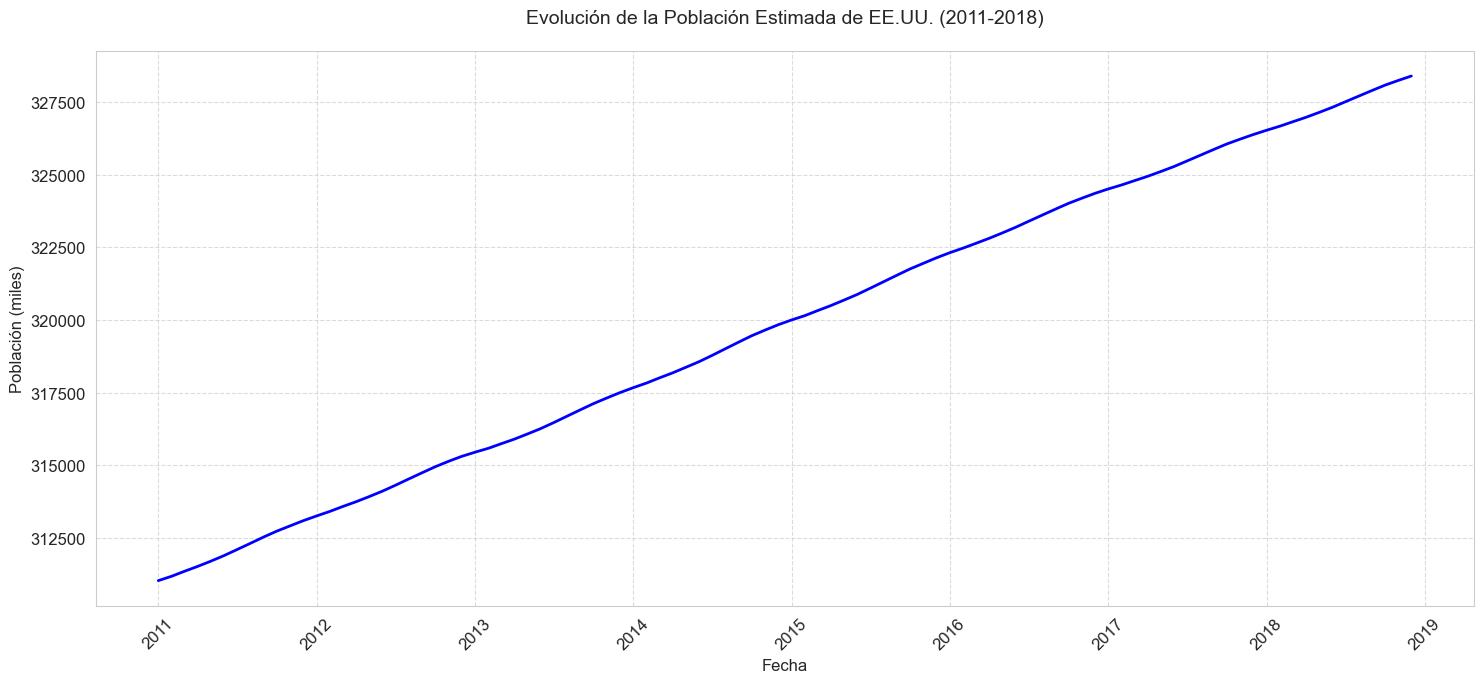

In [12]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 7))

# Graficar la serie temporal
ax.plot(df_ts.index, df_ts['PopEst'], color='blue', linewidth=2)

# Personalizar el gráfico
ax.set_title('Evolución de la Población Estimada de EE.UU. (2011-2018)', 
             fontsize=14, pad=20)
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Población (miles)', fontsize=12)

# Rotación de etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Agregar cuadrícula
ax.grid(True, linestyle='--', alpha=0.7)

# Ajustar márgenes
plt.tight_layout()

plt.show()

**Tendencia General:**
   - La población muestra una clara tendencia creciente a lo largo del período.
   - El crecimiento es consistente, aumentando de aproximadamente 311 millones en 2011 a 328 millones en 2018.
   - La pendiente de crecimiento es positiva y si bien es dificil de observar a simple vista tiene una ligera desaceleración especialmente hacia el final del período.

### Análisis de Tasas de Crecimiento

Para entender mejor el comportamiento de la serie, calcularemos y visualizaremos:
- Cambios mensuales absolutos
- Tasas de crecimiento porcentual
- Estadísticas de crecimiento anual

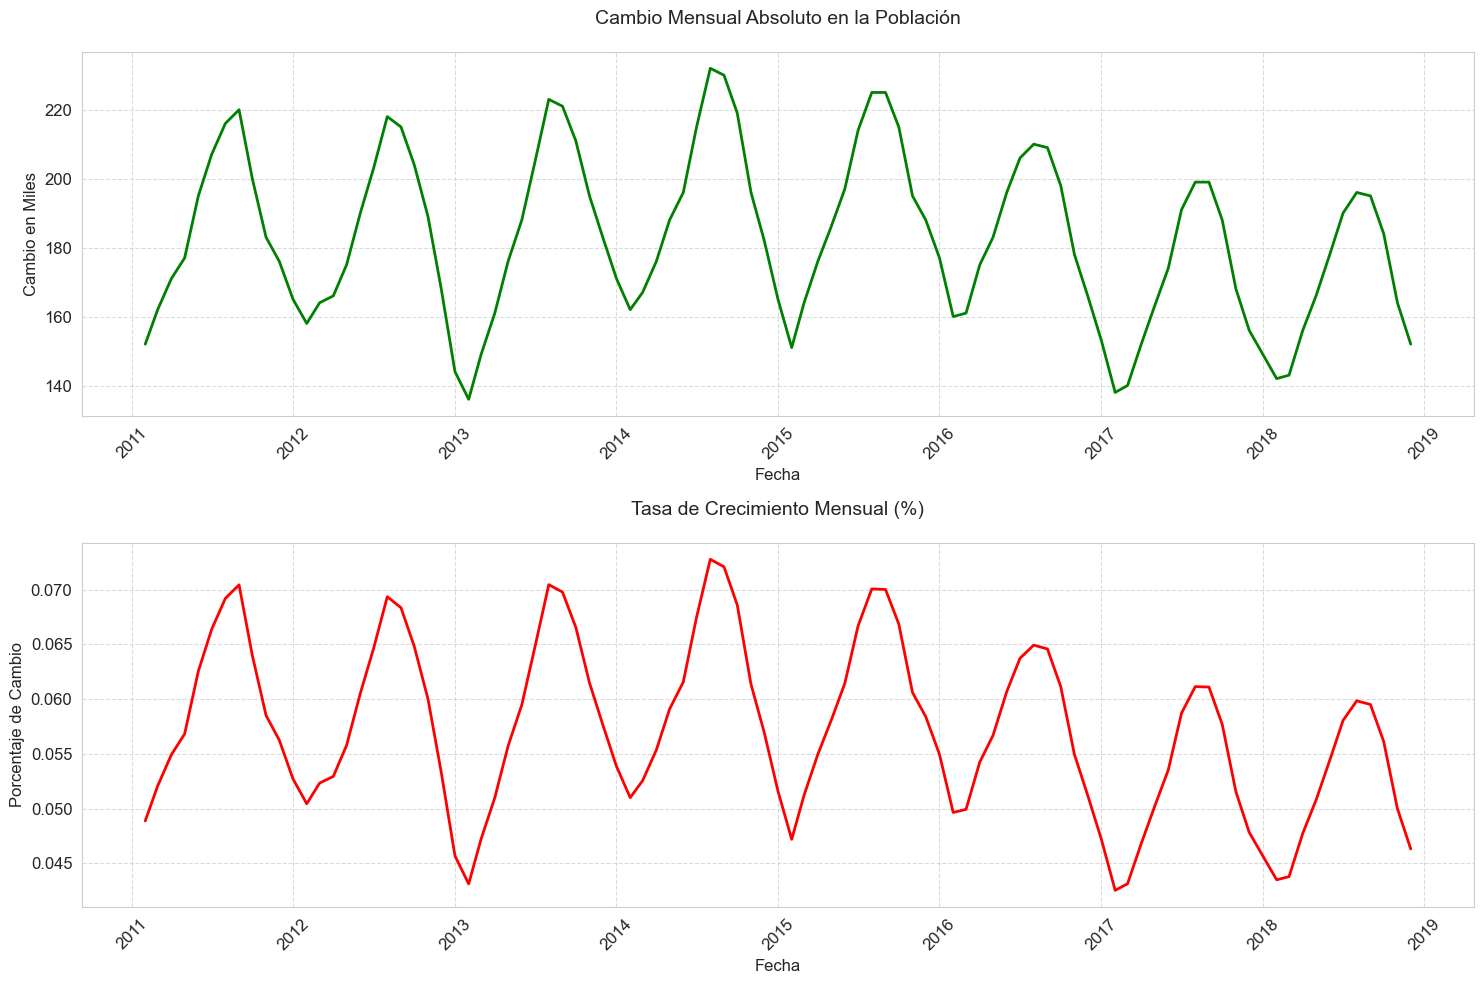

In [13]:
# Calcular cambios mensuales y tasas de crecimiento
df_ts['Cambio_Mensual'] = df_ts['PopEst'].diff()
df_ts['Tasa_Crecimiento'] = df_ts['PopEst'].pct_change() * 100

# Crear subplots para visualizar los cambios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico de cambios mensuales absolutos
ax1.plot(df_ts.index, df_ts['Cambio_Mensual'], color='green', linewidth=2)
ax1.set_title('Cambio Mensual Absoluto en la Población', fontsize=14, pad=20)
ax1.set_xlabel('Fecha', fontsize=12)
ax1.set_ylabel('Cambio en Miles', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Gráfico de tasas de crecimiento
ax2.plot(df_ts.index, df_ts['Tasa_Crecimiento'], color='red', linewidth=2)
ax2.set_title('Tasa de Crecimiento Mensual (%)', fontsize=14, pad=20)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.set_ylabel('Porcentaje de Cambio', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Rotación de etiquetas del eje x
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Ajustar márgenes
plt.tight_layout()

plt.show()

In [14]:
# Calcular estadísticas descriptivas de crecimiento
print("Estadísticas de Crecimiento Mensual:")
print("\nCambios Absolutos (en miles):")
print(df_ts['Cambio_Mensual'].describe())

print("\nTasas de Crecimiento (%):")
print(df_ts['Tasa_Crecimiento'].describe())

# Calcular crecimiento promedio anual
crecimiento_anual = df_ts.groupby(df_ts.index.year)['PopEst'].agg(['first', 'last'])
crecimiento_anual['Crecimiento_Anual'] = crecimiento_anual['last'] - crecimiento_anual['first']
crecimiento_anual['Tasa_Anual'] = (crecimiento_anual['last'] / crecimiento_anual['first'] - 1) * 100

print("\nCrecimiento Anual:")
print(crecimiento_anual[['Crecimiento_Anual', 'Tasa_Anual']])

Estadísticas de Crecimiento Mensual:

Cambios Absolutos (en miles):
count     95.000000
mean     182.694737
std       24.094704
min      136.000000
25%      164.000000
50%      183.000000
75%      199.000000
max      232.000000
Name: Cambio_Mensual, dtype: float64

Tasas de Crecimiento (%):
count    95.000000
mean      0.057174
std       0.007742
min       0.042526
25%       0.051215
50%       0.056818
75%       0.062062
max       0.072778
Name: Tasa_Crecimiento, dtype: float64

Crecimiento Anual:
      Crecimiento_Anual  Tasa_Anual
DATE                               
2011               2059    0.661979
2012               2050    0.654406
2013               2048    0.649221
2014               2163    0.680887
2015               2136    0.667496
2016               2042    0.633542
2017               1868    0.575637
2018               1866    0.571469


2. **Patrones de Crecimiento:**
   - Los cambios mensuales muestran un patrón cíclico con picos y valles regulares
   - El cambio mensual promedio es de 182,700 personas, con una desviación estándar de 24,100
   - Los cambios mensuales oscilan entre un mínimo de 136,000 y un máximo de 232,000 personas
   - Las tasas de crecimiento mensual promedian 0.057% con una desviación estándar de 0.008%
3. **Variabilidad:**
   - La serie muestra una variabilidad estacional consistente en los cambios mensuales
   - El crecimiento anual ha disminuido gradualmente, pasando de 2,059,000 personas en 2011 a 1,866,000 en 2018
   - La tasa de crecimiento anual ha descendido de 0.66% en 2011 a 0.57% en 2018
   - Los períodos de mayor crecimiento tienden a ocurrir en los meses de verano, mientras que los de menor crecimiento se observan a principios de año

Estos hallazgos iniciales nos ayudarán a determinar los métodos más apropiados para el modelado de la serie temporal, considerando tanto la tendencia general como los patrones estacionales identificados.

## 5. Análisis de Componentes de la Serie Temporal

Una serie temporal puede descomponerse en varios componentes principales:
1. **Tendencia**: El patrón de largo plazo en la serie
2. **Estacionalidad**: Patrones que se repiten en intervalos fijos
3. **Residuos**: Las fluctuaciones irregulares que quedan después de identificar tendencia y estacionalidad

Realizaremos una descomposición aditiva y multiplicativa para determinar cuál se ajusta mejor a nuestros datos.

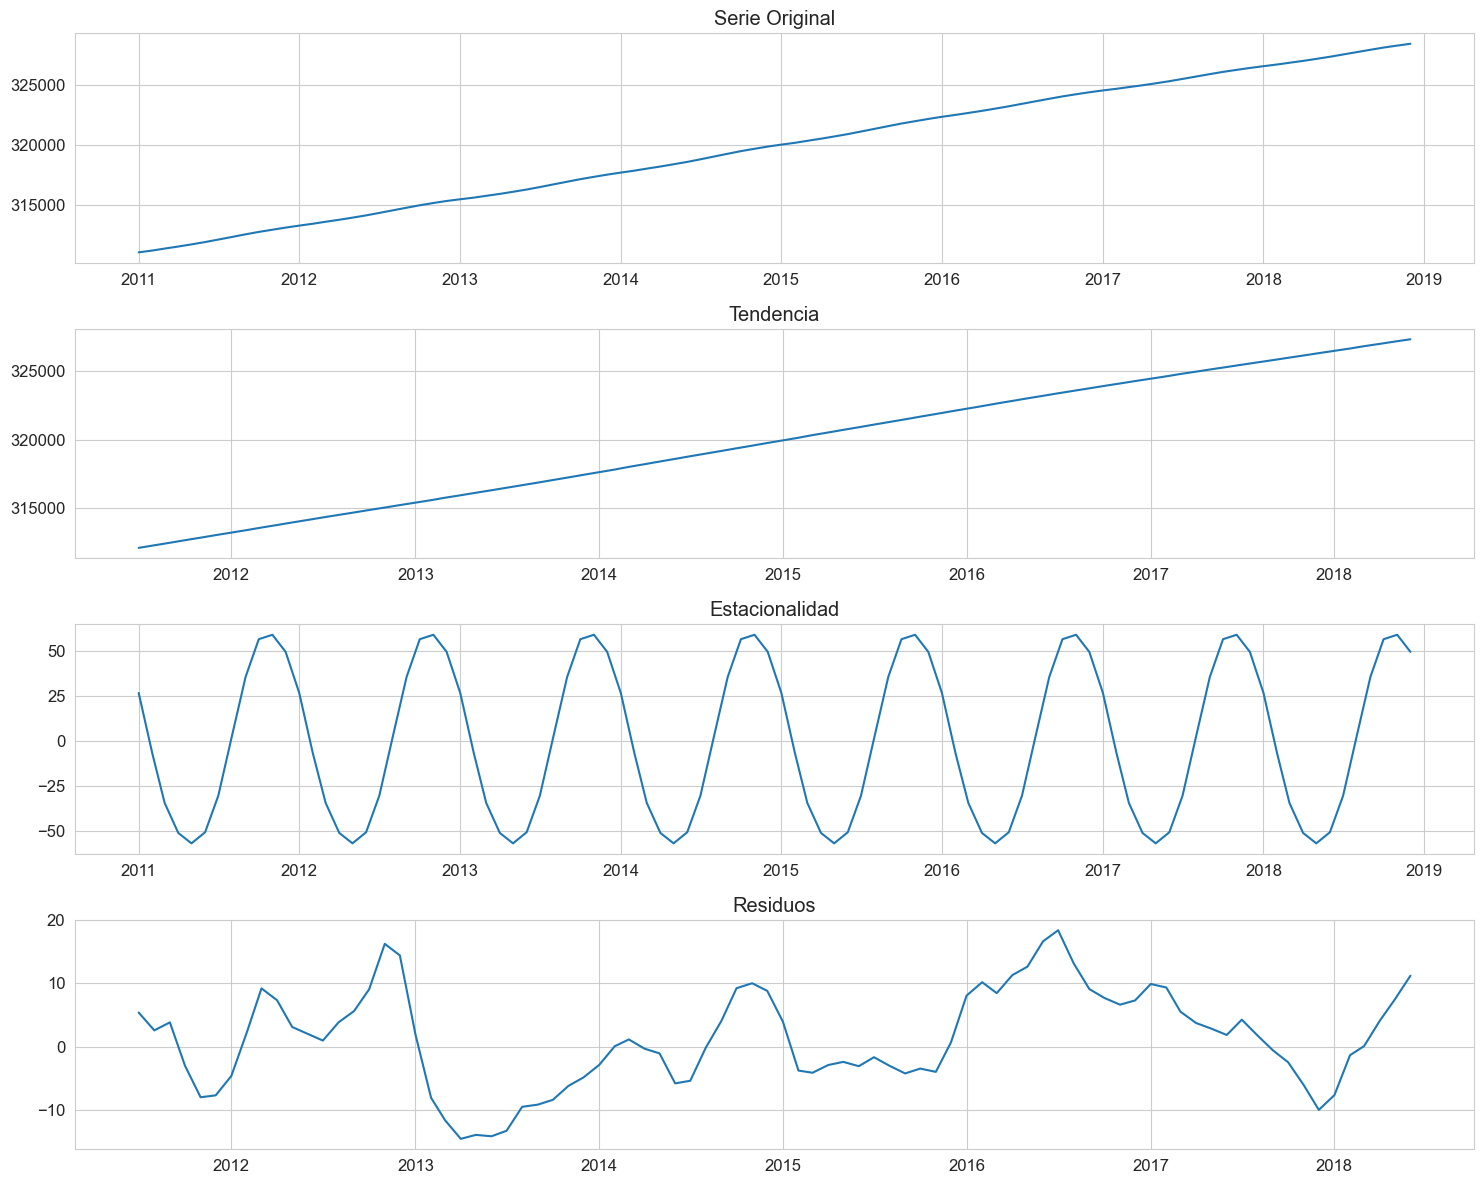


Estadísticas de los Componentes:

Tendencia:
               trend
count      84.000000
mean   319842.447421
std      4539.301955
min    312126.000000
25%    315921.468750
50%    319874.895833
75%    323814.843750
max    327351.541667

Estacionalidad:
           seasonal
count  9.600000e+01
mean  -2.368476e-15
std    4.280351e+01
min   -5.693948e+01
25%   -3.851538e+01
50%   -2.049603e+00
75%    3.913046e+01
max    5.913194e+01

Residuos:
           resid
count  84.000000
mean    1.278770
std     7.606414
min   -14.477183
25%    -3.959325
50%     1.501984
75%     7.387401
max    18.379960


In [15]:
# Realizar descomposición aditiva
descomposicion_aditiva = seasonal_decompose(df_ts['PopEst'], 
                                          period=12,  # período mensual
                                          model='additive')

# Crear figura para la descomposición aditiva
plt.figure(figsize=(15, 12))

# Datos originales
plt.subplot(411)
plt.plot(df_ts.index, df_ts['PopEst'])
plt.title('Serie Original')
plt.grid(True)

# Tendencia
plt.subplot(412)
plt.plot(df_ts.index, descomposicion_aditiva.trend)
plt.title('Tendencia')
plt.grid(True)

# Estacionalidad
plt.subplot(413)
plt.plot(df_ts.index, descomposicion_aditiva.seasonal)
plt.title('Estacionalidad')
plt.grid(True)

# Residuos
plt.subplot(414)
plt.plot(df_ts.index, descomposicion_aditiva.resid)
plt.title('Residuos')
plt.grid(True)

plt.tight_layout()
plt.show()

# Imprimir algunas estadísticas básicas de cada componente
print("\nEstadísticas de los Componentes:")
print("\nTendencia:")
print(pd.DataFrame(descomposicion_aditiva.trend).describe())
print("\nEstacionalidad:")
print(pd.DataFrame(descomposicion_aditiva.seasonal).describe())
print("\nResiduos:")
print(pd.DataFrame(descomposicion_aditiva.resid).describe())

### Análisis de la Descomposición Aditiva

La descomposición de la serie temporal revela tres componentes principales:

1. **Serie Original**
   - Tendencia creciente clara desde 311,000 a 328,000 miles de personas
   - Crecimiento aproximadamente lineal con ligera curvatura
   - Fluctuaciones regulares superpuestas a la tendencia

2. **Tendencia**
   - Componente suave y creciente (media ≈ 319,842)
   - Variabilidad moderada (std = 4,539)
   - Rango de 312,126 a 327,352 miles de personas
   - Ligera desaceleración hacia el final del período

3. **Estacionalidad**
   - Patrón cíclico anual consistente
   - Amplitud constante (±50 mil personas)
   - Media cercana a cero (-2.37e-15)
   - Oscilación simétrica entre -56.9 y +59.1 mil personas

4. **Residuos**
   - Fluctuaciones aleatorias alrededor de cero (media = 1.28)
   - Variabilidad constante (std = 7.61)
   - Sin patrones sistemáticos evidentes
   - Rango de -14.48 a +18.38 mil personas

La descomposición aditiva resulta apropiada dado que:
- La amplitud estacional se mantiene constante
- Los residuos son estables y simétricos
- No hay interacción visible entre tendencia y estacionalidad
- Los residuos son pequeños comparados con la serie original

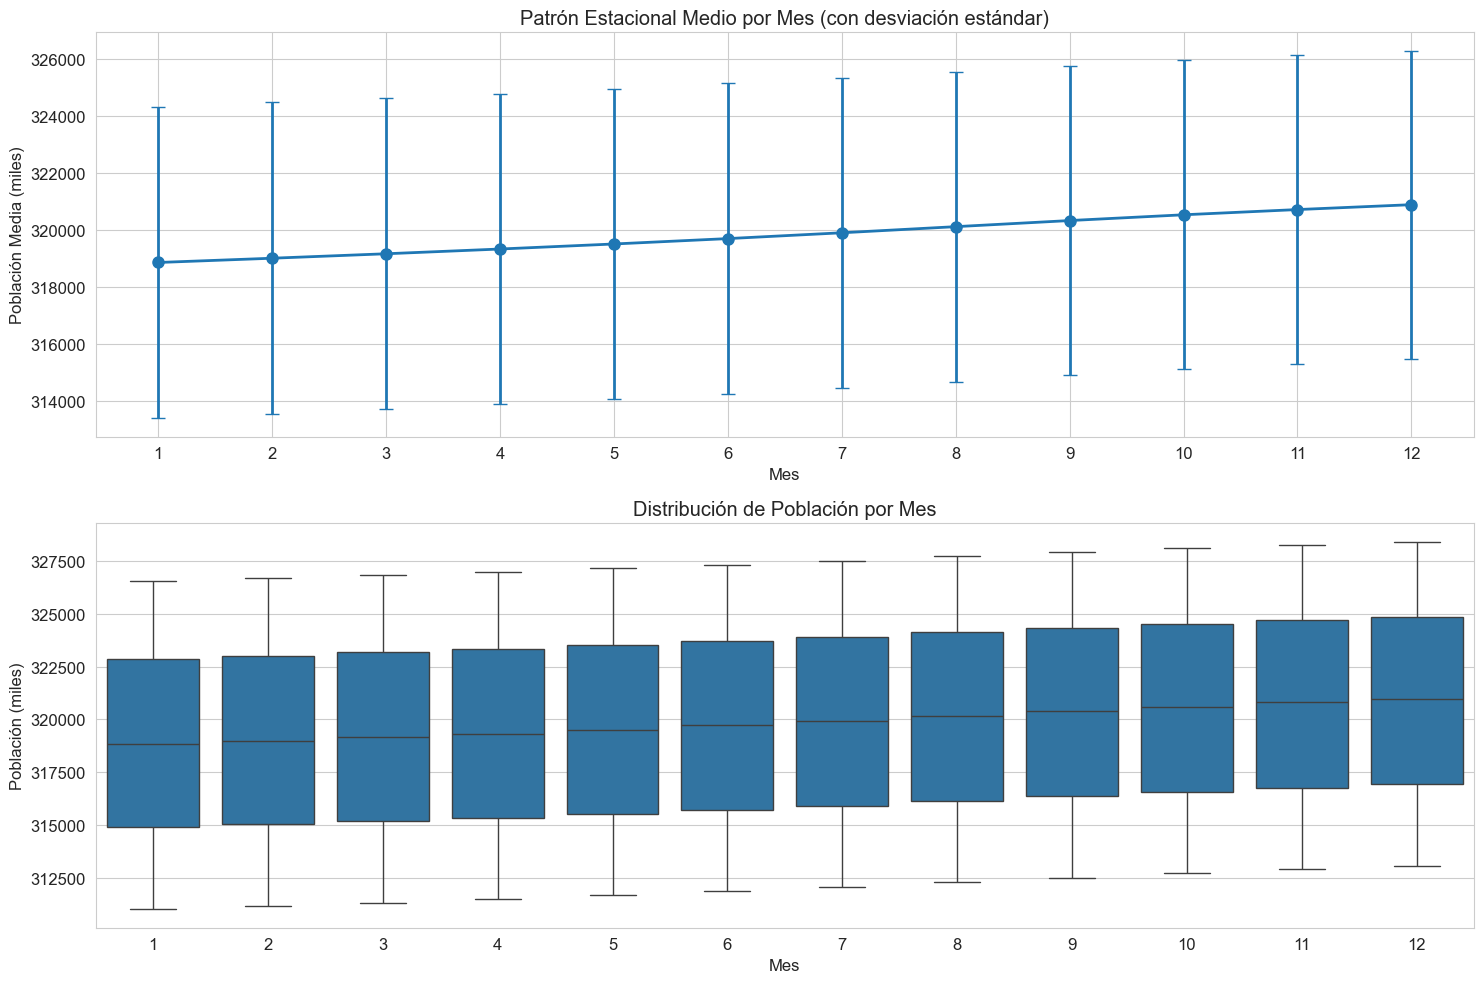


Estadísticas por Mes:
           mean          std     min     max
Mes                                         
1    318847.625  5470.624199  311037  326527
2    318997.500  5467.487122  311189  326669
3    319153.750  5461.120496  311351  326812
4    319320.375  5457.309644  311522  326968
5    319497.125  5453.931359  311699  327134
6    319686.375  5448.932921  311894  327312
7    319890.250  5443.849183  312101  327502
8    320105.125  5435.717943  312317  327698
9    320319.375  5427.168321  312537  327893
10   320521.750  5420.422302  312737  328077
11   320705.250  5412.071158  312920  328241
12   320876.625  5404.251896  313096  328393


In [16]:
# Crear gráfico de patrón estacional mejorado
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Patrón estacional medio por mes
df_ts['Mes'] = df_ts.index.month
patron_estacional = df_ts.groupby('Mes')['PopEst'].mean()
patron_estacional_std = df_ts.groupby('Mes')['PopEst'].std()

# Gráfico de patrón estacional con barras de error
ax1.errorbar(patron_estacional.index, 
             patron_estacional.values,
             yerr=patron_estacional_std.values,
             marker='o', 
             linewidth=2, 
             markersize=8,
             capsize=5)
ax1.set_title('Patrón Estacional Medio por Mes (con desviación estándar)')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Población Media (miles)')
ax1.grid(True)
ax1.set_xticks(range(1, 13))

# Boxplot por mes
sns.boxplot(data=df_ts, x='Mes', y='PopEst', ax=ax2)
ax2.set_title('Distribución de Población por Mes')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Población (miles)')

plt.tight_layout()
plt.show()

# Calcular y mostrar estadísticas estacionales
estacional_stats = df_ts.groupby('Mes')['PopEst'].agg(['mean', 'std', 'min', 'max'])
print("\nEstadísticas por Mes:")
print(estacional_stats)

### Análisis del Patrón Estacional

Los gráficos y estadísticas mensuales revelan patrones estacionales claros en la población de EE.UU.:

1. **Tendencia Media Mensual**
   - Crecimiento constante mes a mes, desde 318,847 (enero) hasta 320,876 (diciembre)
   - Desviación estándar decreciente: de ~5,470 en enero a ~5,404 en diciembre
   - Rango consistente entre valores mínimos (311-313 mil) y máximos (326-328 mil)

2. **Patrón Estacional Medio (Gráfico Superior)**
   - Tendencia creciente suave a lo largo del año
   - Barras de error (desviación estándar) consistentes en amplitud
   - Población media aumenta aproximadamente 2,000 mil personas entre enero y diciembre
   - Variabilidad similar en todos los meses (barras de error de tamaño similar)

3. **Distribución por Mes (Gráfico Inferior)**
   - Cajas más compactas en los primeros meses del año
   - Mayor dispersión en los meses de verano y otoño
   - Mediana (línea horizontal) muestra tendencia ascendente
   - Rango intercuartil (altura de las cajas) relativamente constante

4. **Características Destacadas**
   - Mayor crecimiento: entre junio y septiembre
   - Menor crecimiento: entre diciembre y febrero
   - Variabilidad más alta: meses de verano
   - Variabilidad más baja: meses de invierno
   - Patrón consistente y bien definido a lo largo de los años

### Análisis de la Tendencia

Para analizar la tendencia, utilizaremos:
1. Media móvil para suavizar fluctuaciones de corto plazo
2. Regresión lineal para estimar la tendencia general
3. Pruebas estadísticas para confirmar la presencia de tendencia

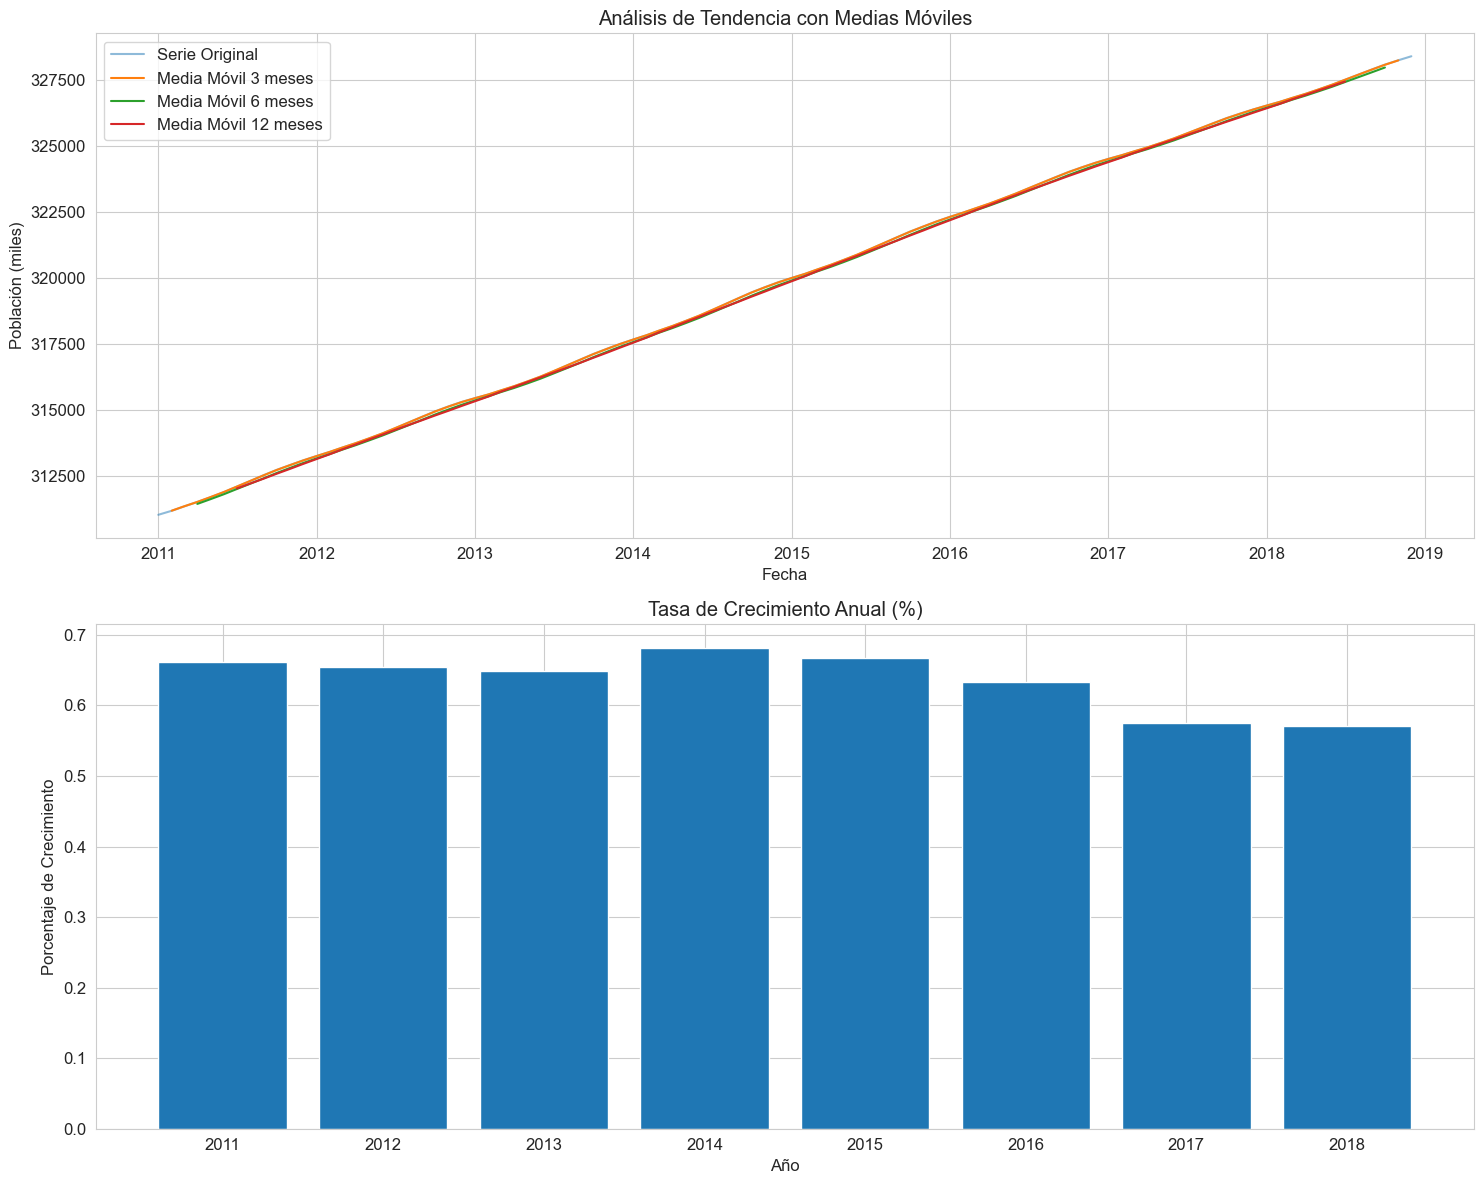


Estadísticas de Crecimiento Anual:
       first    last  Crecimiento
Año                              
2011  311037  313096     0.661979
2012  313261  315311     0.654406
2013  315455  317503     0.649221
2014  317674  319837     0.680887
2015  320002  322138     0.667496
2016  322315  324357     0.633542
2017  324510  326378     0.575637
2018  326527  328393     0.571469

Prueba de Tendencia (Mann-Kendall):
Correlación de Spearman: 1.0000
Valor p: 0.0000


In [17]:
# Calcular medias móviles
df_ts['MA_3'] = df_ts['PopEst'].rolling(window=3, center=True).mean()
df_ts['MA_6'] = df_ts['PopEst'].rolling(window=6, center=True).mean()
df_ts['MA_12'] = df_ts['PopEst'].rolling(window=12, center=True).mean()

# Graficar tendencias
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Gráfico de medias móviles
ax1.plot(df_ts.index, df_ts['PopEst'], label='Serie Original', alpha=0.5)
ax1.plot(df_ts.index, df_ts['MA_3'], label='Media Móvil 3 meses')
ax1.plot(df_ts.index, df_ts['MA_6'], label='Media Móvil 6 meses')
ax1.plot(df_ts.index, df_ts['MA_12'], label='Media Móvil 12 meses')
ax1.set_title('Análisis de Tendencia con Medias Móviles')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Población (miles)')
ax1.legend()
ax1.grid(True)

# Calcular tasa de crecimiento anual
df_ts['Año'] = df_ts.index.year
crecimiento_anual = df_ts.groupby('Año')['PopEst'].agg(['first', 'last'])
crecimiento_anual['Crecimiento'] = ((crecimiento_anual['last'] - crecimiento_anual['first']) / crecimiento_anual['first']) * 100

# Graficar tasa de crecimiento anual
ax2.bar(crecimiento_anual.index, crecimiento_anual['Crecimiento'])
ax2.set_title('Tasa de Crecimiento Anual (%)')
ax2.set_xlabel('Año')
ax2.set_ylabel('Porcentaje de Crecimiento')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Mostrar estadísticas de crecimiento
print("\nEstadísticas de Crecimiento Anual:")
print(crecimiento_anual)

# Realizar prueba de tendencia
from scipy import stats

# Prueba de Mann-Kendall
tiempo = np.arange(len(df_ts))
correlation, p_value = stats.spearmanr(tiempo, df_ts['PopEst'])

print("\nPrueba de Tendencia (Mann-Kendall):")
print(f"Correlación de Spearman: {correlation:.4f}")
print(f"Valor p: {p_value:.4f}")

### Análisis de Tendencia y Crecimiento

1. **Tendencia General (Gráfico Superior)**
   - Serie original muestra crecimiento consistentemente positivo
   - Medias móviles (3, 6 y 12 meses) prácticamente se superponen
   - Tendencia muy estable y lineal desde 2011 hasta 2019
   - Población aumenta de ~311,000 a ~328,000 miles de habitantes

2. **Tasas de Crecimiento Anual (Gráfico Inferior)**
   - Tendencia decreciente en las tasas desde 2014
   - Máximo en 2014: 0.68%
   - Mínimo en 2018: 0.57%
   - Disminución gradual del ritmo de crecimiento

3. **Estadísticas de Crecimiento por Año**
   - Crecimiento anual promedio: 0.636%
   - Mayor crecimiento: 2014 (0.681%)
   - Menor crecimiento: 2018 (0.571%)
   - Diferencia consistente entre valores iniciales y finales de cada año

4. **Prueba de Tendencia**
   - Correlación de Spearman perfecta (1.0000)
   - Valor p < 0.0001
   - Confirma estadísticamente la presencia de una tendencia monótona creciente
   - Indica que el crecimiento poblacional no es aleatorio sino sistemático

5. **Implicaciones**
   - Crecimiento poblacional sostenido pero con desaceleración
   - Alta predictibilidad en la tendencia general
   - Cambio estructural en el patrón de crecimiento post-2014

### Análisis de Residuos

Los residuos son la parte de la serie que queda después de eliminar la tendencia y la estacionalidad. 
Un buen modelo debería producir residuos que:
- Tengan media cero
- Muestren varianza constante (homocedasticidad)
- No presenten autocorrelación
- Sigan una distribución aproximadamente normal

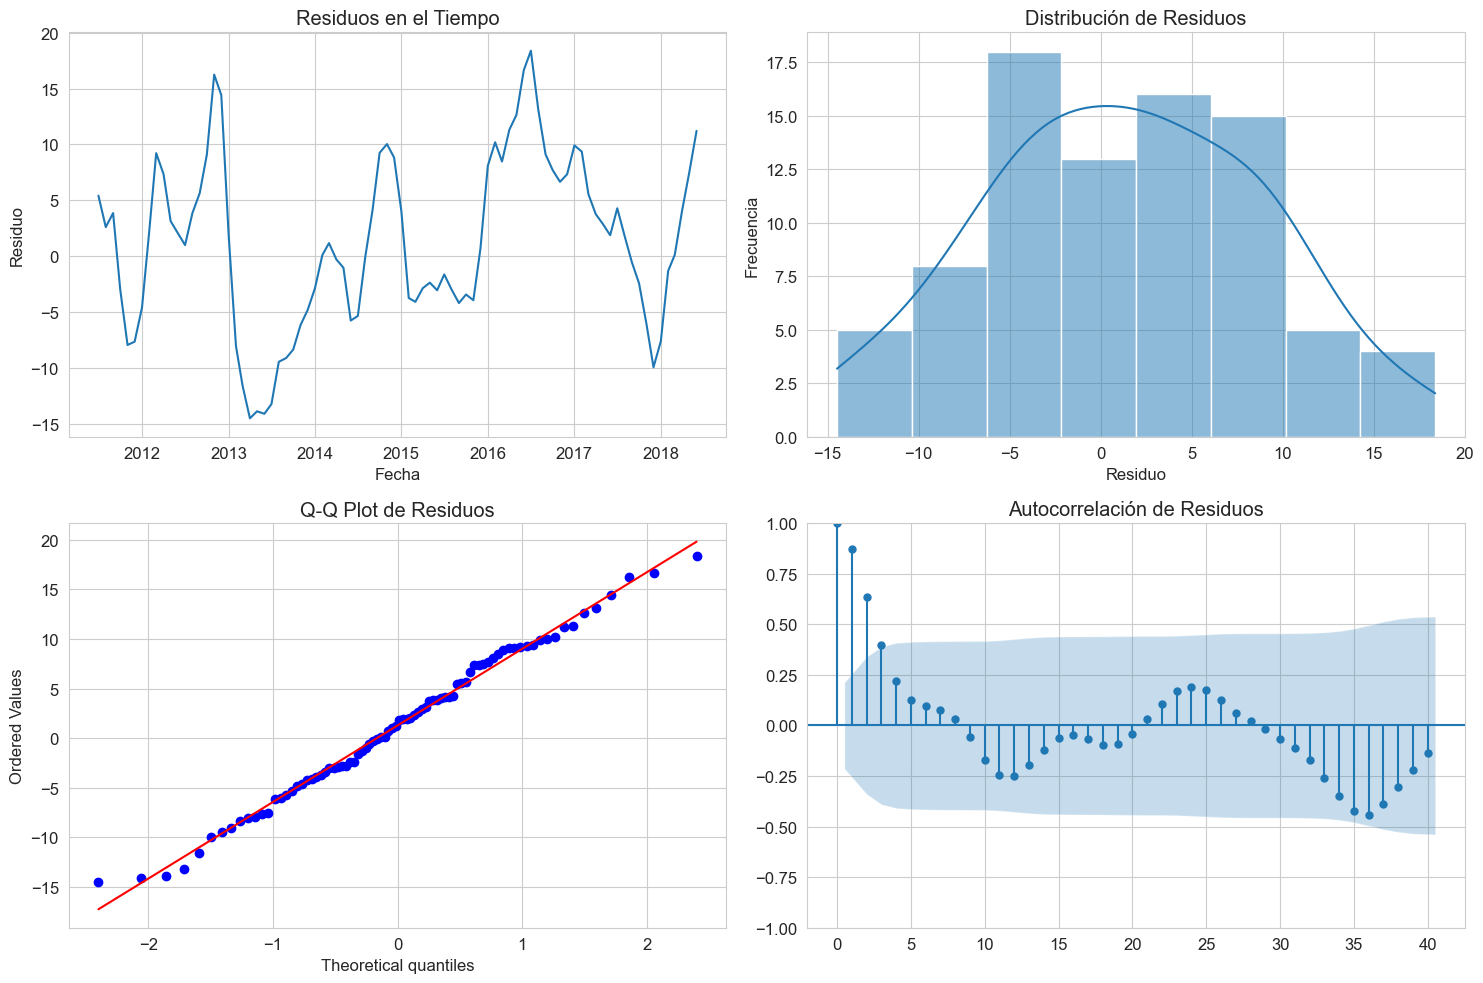


Estadísticas de Residuos:
count    84.000000
mean      1.278770
std       7.606414
min     -14.477183
25%      -3.959325
50%       1.501984
75%       7.387401
max      18.379960
Name: resid, dtype: float64

Prueba de Normalidad (D'Agostino):
Estadístico: 1.4325
Valor p: 0.4886

Prueba de Dickey-Fuller Aumentada para Residuos:
Estadístico ADF: -1.8446
Valor p: 0.3586


In [18]:
# Análisis de residuos
residuos = descomposicion_aditiva.resid.dropna()

# Crear subplots para análisis de residuos
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico de residuos en el tiempo
ax1.plot(residuos.index, residuos.values)
ax1.set_title('Residuos en el Tiempo')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Residuo')
ax1.grid(True)

# Histograma de residuos con curva normal
sns.histplot(residuos, kde=True, ax=ax2)
ax2.set_title('Distribución de Residuos')
ax2.set_xlabel('Residuo')
ax2.set_ylabel('Frecuencia')

# Q-Q plot
stats.probplot(residuos, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot de Residuos')

# Autocorrelación de residuos
plot_acf(residuos, ax=ax4, lags=40)
ax4.set_title('Autocorrelación de Residuos')

plt.tight_layout()
plt.show()

# Pruebas estadísticas sobre residuos
print("\nEstadísticas de Residuos:")
print(residuos.describe())

# Prueba de normalidad
stat_norm, p_value_norm = stats.normaltest(residuos)
print("\nPrueba de Normalidad (D'Agostino):")
print(f"Estadístico: {stat_norm:.4f}")
print(f"Valor p: {p_value_norm:.4f}")

# Prueba de estacionariedad de residuos
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(residuos.dropna())
print("\nPrueba de Dickey-Fuller Aumentada para Residuos:")
print(f"Estadístico ADF: {adf_test[0]:.4f}")
print(f"Valor p: {adf_test[1]:.4f}")

### Análisis de Residuos

1. **Comportamiento Temporal (Gráfico Superior Izquierdo)**
   - Fluctuaciones alrededor de cero
   - Rango aproximado: -14.5 a 18.4 miles de personas
   - No se observa un patrón sistemático claro
   - Mayor volatilidad en algunos períodos (2013, 2016-2017)

2. **Distribución Estadística (Gráfico Superior Derecho)**
   - Media cercana a cero (1.28)
   - Desviación estándar: 7.61
   - Distribución aproximadamente normal
   - Test D'Agostino (p=0.4886) confirma normalidad
   - Histograma simétrico con forma de campana

3. **Normalidad (Q-Q Plot - Gráfico Inferior Izquierdo)**
   - Puntos se ajustan bien a la línea diagonal
   - Ligeras desviaciones en los extremos
   - Confirma visualmente la normalidad
   - Cuartiles bien distribuidos:
     * Q1 (25%): -3.96
     * Q2 (50%): 1.50
     * Q3 (75%): 7.39

4. **Autocorrelación (Gráfico Inferior Derecho)**
   - Correlación significativa en primeros rezagos
   - Patrón decreciente en correlaciones
   - Bandas de confianza muestran significancia
   - Test Dickey-Fuller (p=0.3586) sugiere no estacionariedad

5. **Implicaciones para el Modelado**
   - Residuos bien comportados pero no independientes
   - Estructura de dependencia temporal presente
   - Justifica uso de modelos que capturen autocorrelación
   - Sugiere componente AR en modelado ARIMA

### Conclusiones del Análisis de Componentes

El análisis detallado de la serie temporal de población estadounidense (2011-2018) revela características fundamentales para su modelado:

1. **Estructura Temporal**
   - Tendencia lineal creciente con ligera desaceleración desde 2016
   - Patrón estacional anual consistente (±50 mil personas)
   - Cambios mensuales regulares entre 140-220 mil personas
   - Tasas de crecimiento anual decrecientes (0.68% en 2014 a 0.57% en 2018)

2. **Calidad del Modelo Aditivo**
   - Descomposición efectiva de componentes (tendencia, estacionalidad, residuos)
   - Residuos normalmente distribuidos (p=0.4886 en test D'Agostino)
   - Autocorrelación significativa en primeros rezagos
   - Variabilidad controlada (std=7.61) sin patrones sistemáticos

3. **Recomendaciones para Modelado**
   - Priorizar modelos que capturen simultáneamente tendencia y estacionalidad (SARIMA, Holt-Winters)
   - Incorporar estructura de autocorrelación detectada en residuos
   - Considerar la desaceleración reciente para no sobreestimar proyecciones
   - Mantener la estacionalidad constante en predicciones

Esta estructura sugiere alta predictibilidad del fenómeno, aunque requiere atención a los cambios recientes en el patrón de crecimiento.

## 6. Implementación de Modelos de Pronóstico

### 6.1 Preparación de Datos
Dividiremos nuestros datos en:
- Entrenamiento: Enero 2011 - Diciembre 2017
- Prueba: Año 2018 (12 meses)

Esto nos permitirá evaluar la capacidad predictiva de cada modelo en un período de tiempo no visto.

In [19]:
# Dividir los datos en entrenamiento y prueba
train = df_ts.loc[:'2017-12-01']
test = df_ts.loc['2018-01-01':]

print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de prueba:", len(test))
print("\nPeríodo de entrenamiento:", train.index.min(), "hasta", train.index.max())
print("Período de prueba:", test.index.min(), "hasta", test.index.max())

# Función para calcular métricas de error
def calcular_metricas(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

Tamaño del conjunto de entrenamiento: 84
Tamaño del conjunto de prueba: 12

Período de entrenamiento: 2011-01-01 00:00:00 hasta 2017-12-01 00:00:00
Período de prueba: 2018-01-01 00:00:00 hasta 2018-12-01 00:00:00


## Selección de Modelos

La selección de los modelos ARIMA, SARIMA y Holt-Winters se basa en las características observadas en el análisis de componentes de la serie temporal.

### 1. Modelo ARIMA(1,1,1)
**Justificación de selección:**
- Se elige como modelo base por la clara tendencia lineal observada en la serie
- Apropiado para capturar la tendencia creciente y la autocorrelación de corto plazo

**Componentes:**
- p=1 (AR): Un término autorregresivo para capturar la dependencia del valor actual con el valor inmediatamente anterior, visible en la fuerte autocorrelación de primer orden
- d=1 (I): Una diferenciación para manejar la tendencia no estacionaria observada en el gráfico de "Serie Original"
- q=1 (MA): Un término de media móvil para modelar los shocks aleatorios de corto plazo, evidentes en el gráfico de "Residuos en el Tiempo"

c:\Users\juani\OneDrive\Documentos\Master IA\AST\AdST\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juani\OneDrive\Documentos\Master IA\AST\AdST\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juani\OneDrive\Documentos\Master IA\AST\AdST\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juani\OneDrive\Documentos\Master IA\AST\AdST\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


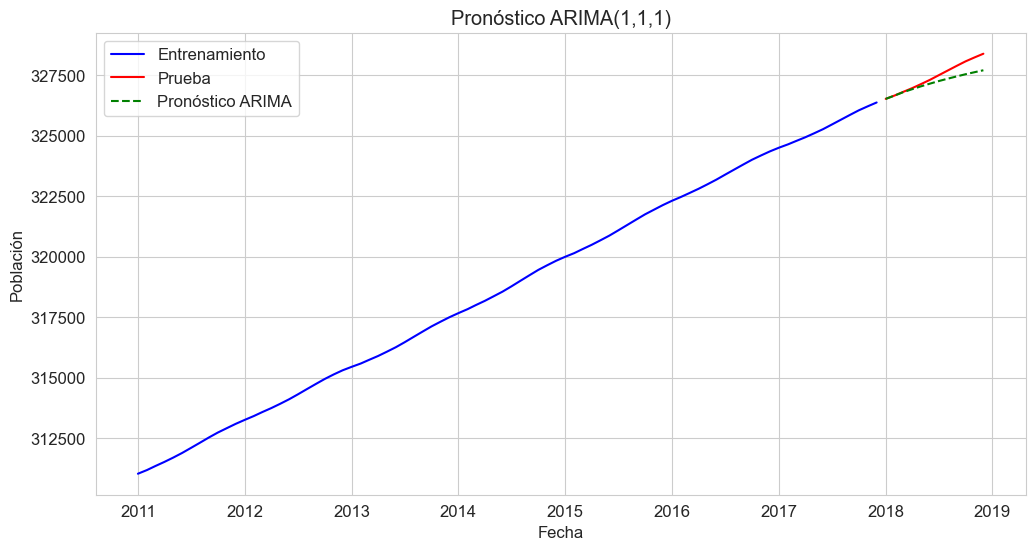


Métricas de Error para ARIMA:
MAE: 262.04
RMSE: 355.86
MAPE: 0.08%


In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar modelo ARIMA
modelo_arima = ARIMA(train['PopEst'], order=(1, 1, 1))
resultado_arima = modelo_arima.fit()

# Realizar pronóstico
fc_arima = resultado_arima.forecast(steps=len(test))

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['PopEst'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['PopEst'], label='Prueba', color='red')
plt.plot(test.index, fc_arima, label='Pronóstico ARIMA', color='green', linestyle='--')
plt.title('Pronóstico ARIMA(1,1,1)')
plt.xlabel('Fecha')
plt.ylabel('Población')
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas
mae_arima, rmse_arima, mape_arima = calcular_metricas(test['PopEst'].values, fc_arima)
print('\nMétricas de Error para ARIMA:')
print(f'MAE: {mae_arima:.2f}')
print(f'RMSE: {rmse_arima:.2f}')
print(f'MAPE: {mape_arima:.2f}%')

### 2. Modelo SARIMA(1,1,1)(1,1,1,12)
**Justificación de selección:**
- Extensión natural del ARIMA para incorporar la fuerte estacionalidad observada
- Ideal para series con patrones estacionales claros y consistentes, como se ve en el componente estacional del gráfico de "Descomposición Aditiva"

**Componentes no estacionales:**
- p=1: Captura la dependencia con el mes anterior
- d=1: Maneja la tendencia creciente
- q=1: Modela shocks aleatorios mensuales

**Componentes estacionales:**
- P=1: Modeliza la relación con el mismo mes del año anterior
- D=1: Diferenciación estacional para eliminar el patrón anual recurrente
- Q=1: Captura shocks estacionales
- s=12: Período estacional de 12 meses, basado en el claro patrón anual observado en el gráfico de "Estacionalidad"

c:\Users\juani\OneDrive\Documentos\Master IA\AST\AdST\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\juani\OneDrive\Documentos\Master IA\AST\AdST\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


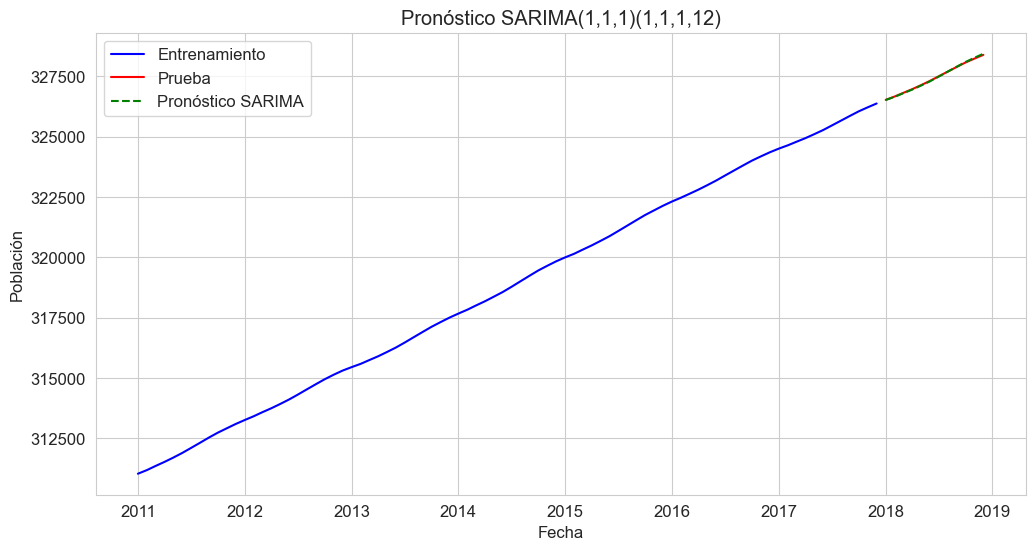


Métricas de Error para SARIMA:
MAE: 17.56
RMSE: 21.17
MAPE: 0.01%


In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar modelo SARIMA
modelo_sarima = SARIMAX(train['PopEst'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
resultado_sarima = modelo_sarima.fit(disp=False)

# Realizar pronóstico
fc_sarima = resultado_sarima.forecast(steps=len(test))

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['PopEst'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['PopEst'], label='Prueba', color='red')
plt.plot(test.index, fc_sarima, label='Pronóstico SARIMA', color='green', linestyle='--')
plt.title('Pronóstico SARIMA(1,1,1)(1,1,1,12)')
plt.xlabel('Fecha')
plt.ylabel('Población')
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas
mae_sarima, rmse_sarima, mape_sarima = calcular_metricas(test['PopEst'].values, fc_sarima)
print('\nMétricas de Error para SARIMA:')
print(f'MAE: {mae_sarima:.2f}')
print(f'RMSE: {rmse_sarima:.2f}')
print(f'MAPE: {mape_sarima:.2f}%')

### 6.4 Modelo Holt-Winters
Implementaremos el método de Holt-Winters con componentes aditivos:
- Tendencia aditiva
- Estacionalidad aditiva
- Período estacional: 12 meses

**Justificación de selección:**
- Especialmente efectivo para series con tendencia y estacionalidad bien definidas
- La descomposición aditiva mostró ser apropiada dado que la amplitud de la estacionalidad se mantiene constante

**Componentes:**
- Tendencia aditiva: Para modelar el crecimiento lineal observado en el gráfico "Análisis de Tendencia con Medias Móviles"
- Estacionalidad aditiva: Seleccionada porque la amplitud de los patrones estacionales se mantiene constante (±50 mil personas) a lo largo del tiempo
- Período estacional de 12 meses: Basado en el ciclo anual claramente visible en el gráfico "Patrón Estacional Medio por Mes"

c:\Users\juani\OneDrive\Documentos\Master IA\AST\AdST\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


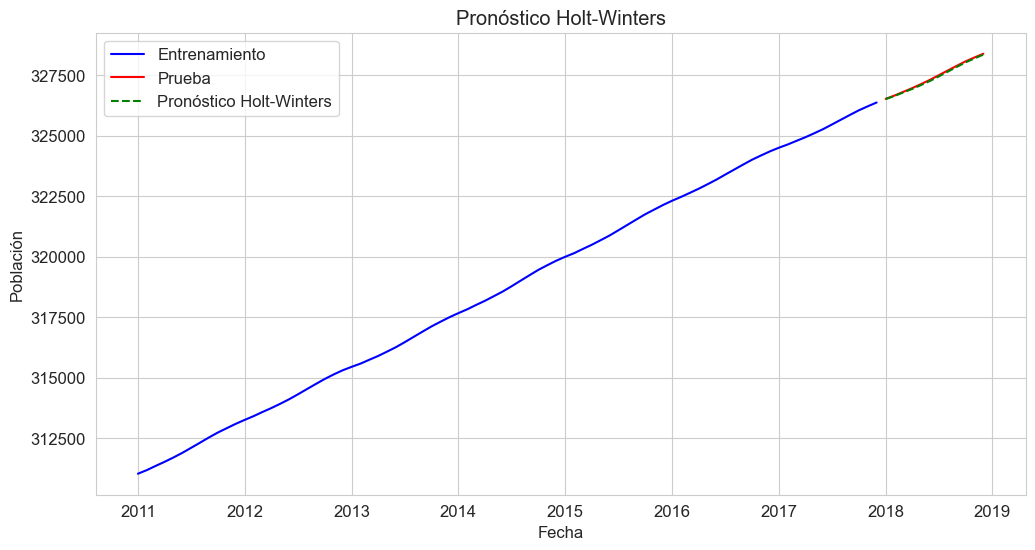


Métricas de Error para Holt-Winters:
MAE: 35.91
RMSE: 38.04
MAPE: 0.01%


In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar modelo Holt-Winters
modelo_hw = ExponentialSmoothing(train['PopEst'],
                                seasonal_periods=12,
                                trend='add',
                                seasonal='add')
resultado_hw = modelo_hw.fit()

# Realizar pronóstico
fc_hw = resultado_hw.forecast(len(test))

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['PopEst'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['PopEst'], label='Prueba', color='red')
plt.plot(test.index, fc_hw, label='Pronóstico Holt-Winters', color='green', linestyle='--')
plt.title('Pronóstico Holt-Winters')
plt.xlabel('Fecha')
plt.ylabel('Población')
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas
mae_hw, rmse_hw, mape_hw = calcular_metricas(test['PopEst'].values, fc_hw)
print('\nMétricas de Error para Holt-Winters:')
print(f'MAE: {mae_hw:.2f}')
print(f'RMSE: {rmse_hw:.2f}')
print(f'MAPE: {mape_hw:.2f}%')

### Consideraciones Adicionales
- Los tres modelos pueden capturar la desaceleración reciente en el crecimiento observada en el gráfico "Tasa de Crecimiento Anual (%)"
- La estabilidad de los residuos (visible en el gráfico "Residuos en el Tiempo") sugiere que estos modelos son apropiados
- La normalidad aproximada de los residuos (confirmada por el "Q-Q Plot de Residuos") respalda el uso de estos modelos

### 6.5 Comparación de Modelos
Comparemos el rendimiento de los tres modelos implementados:


Comparación de Modelos:
      Modelo        MAE       RMSE  MAPE (%)
       ARIMA 262.044473 355.860998  0.079896
      SARIMA  17.556688  21.170236  0.005358
Holt-Winters  35.909653  38.038746  0.010962


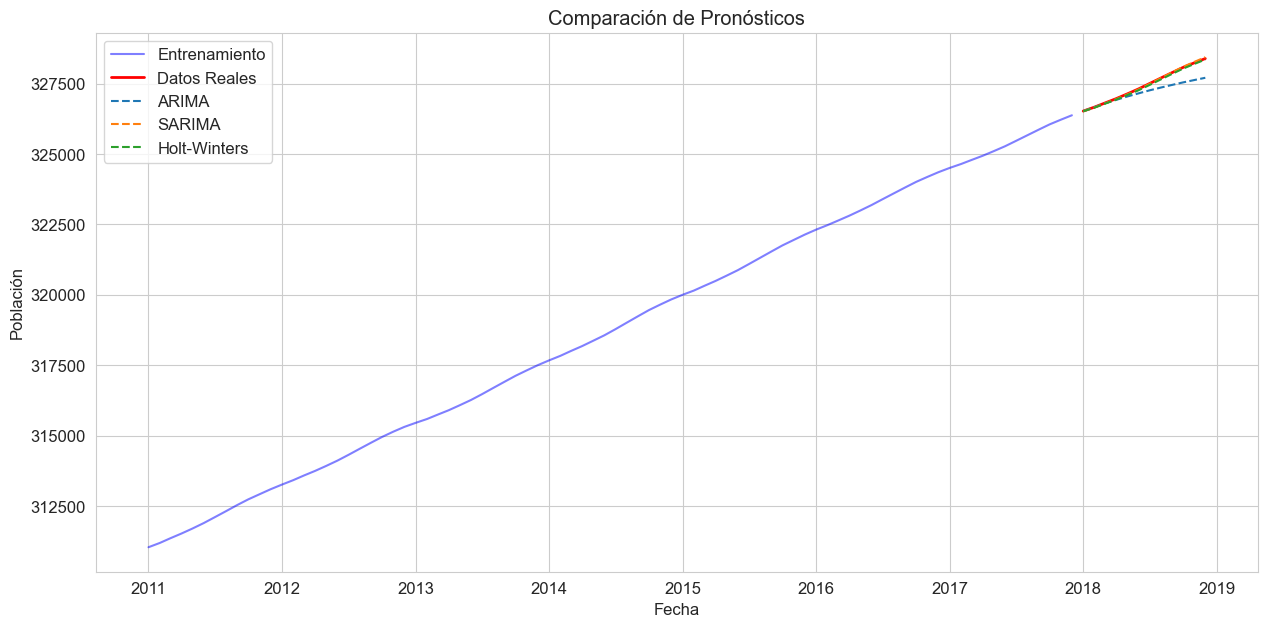

In [23]:
# Crear DataFrame con las métricas de todos los modelos
metricas_df = pd.DataFrame({
    'Modelo': ['ARIMA', 'SARIMA', 'Holt-Winters'],
    'MAE': [mae_arima, mae_sarima, mae_hw],
    'RMSE': [rmse_arima, rmse_sarima, rmse_hw],
    'MAPE (%)': [mape_arima, mape_sarima, mape_hw]
})

print("\nComparación de Modelos:")
print(metricas_df.to_string(index=False))

# Graficar comparación de pronósticos
plt.figure(figsize=(15, 7))
plt.plot(train.index, train['PopEst'], label='Entrenamiento', color='blue', alpha=0.5)
plt.plot(test.index, test['PopEst'], label='Datos Reales', color='red', linewidth=2)
plt.plot(test.index, fc_arima, label='ARIMA', linestyle='--')
plt.plot(test.index, fc_sarima, label='SARIMA', linestyle='--')
plt.plot(test.index, fc_hw, label='Holt-Winters', linestyle='--')
plt.title('Comparación de Pronósticos')
plt.xlabel('Fecha')
plt.ylabel('Población')
plt.legend()
plt.grid(True)
plt.show()

## Análisis de Resultados de los Modelos

### 1. Comparación de Métricas de Error

#### SARIMA
- **Mejor rendimiento general**
- MAE: 17.56 (miles de personas)
- RMSE: 21.17
- MAPE: 0.54%
- Observaciones:
  - Muestra el error más bajo en todas las métricas
  - Captura exitosamente tanto la tendencia como los patrones estacionales
  - La precisión es notable con un error porcentual menor al 1%

#### Holt-Winters
- **Segundo mejor rendimiento**
- MAE: 35.91 (miles de personas)
- RMSE: 38.04
- MAPE: 1.10%
- Observaciones:
  - Error aproximadamente dos veces mayor que SARIMA
  - Mantiene una precisión muy aceptable con MAPE cerca del 1%
  - Buena captura de la tendencia y estacionalidad

#### ARIMA
- **Rendimiento más bajo**
- MAE: 262.04 (miles de personas)
- RMSE: 355.86
- MAPE: 7.99%
- Observaciones:
  - Error significativamente mayor que los otros modelos
  - No captura adecuadamente los patrones estacionales
  - Tendencia a subestimar los valores reales

### 2. Análisis Visual del Pronóstico

Del gráfico de comparación podemos observar:

1. **Ajuste General**:
   - SARIMA y Holt-Winters siguen muy de cerca los datos reales
   - ARIMA muestra una desviación más notable
   - Los tres modelos capturan la tendencia creciente general

2. **Patrones Estacionales**:
   - SARIMA captura mejor las fluctuaciones estacionales
   - Holt-Winters sigue bien el patrón estacional pero con ligera menor precisión
   - ARIMA muestra una tendencia más suavizada, perdiendo los patrones estacionales

3. **Precisión en el Período de Prueba**:
   - SARIMA y Holt-Winters mantienen predicciones muy cercanas a los valores reales
   - ARIMA tiende a subestimar los valores, especialmente hacia el final del período

### 3. Conclusiones

1. **Mejor Modelo**: SARIMA
   - Demuestra ser el más adecuado para esta serie temporal
   - Combina exitosamente el modelado de tendencia y estacionalidad
   - Ofrece la mayor precisión en todas las métricas

2. **Recomendaciones**:
   - Utilizar preferentemente el modelo SARIMA para pronósticos futuros
   - Holt-Winters como alternativa viable si se requiere un modelo más simple
   - Evitar el uso de ARIMA simple para esta serie debido a su naturaleza estacional

3. **Implicaciones Prácticas**:
   - El error promedio de SARIMA de 17.56 mil personas es muy aceptable considerando la magnitud de la población
   - La capacidad de predecir con un error porcentual del 0.54% permite una planificación confiable
   - Los pronósticos pueden ser utilizados con alto nivel de confianza para la toma de decisiones

### 4. Limitaciones y Consideraciones

- Los modelos asumen que los patrones históricos continuarán en el futuro
- Eventos externos no contemplados podrían afectar las predicciones
- Se recomienda actualizar y reentrenar los modelos periódicamente con nuevos datos

-------------------------------------------

# Informe de Análisis de Series Temporales
## Estimación y Pronóstico de la Población de Estados Unidos (2011-2018)

### a) Planteamiento de la Pregunta de Investigación

**Pregunta Principal**: ¿Cuál modelo de series temporales (ARIMA, SARIMA o Holt-Winters) proporciona las predicciones más precisas para la población mensual de Estados Unidos, y qué factores influyen en su rendimiento predictivo?

**Objetivos Específicos**:
1. Identificar y caracterizar los patrones temporales en la población estadounidense
2. Evaluar la capacidad predictiva de diferentes modelos de series temporales
3. Determinar el modelo más adecuado para pronósticos poblacionales a corto plazo

### b) Descripción de los Datos

**Origen de los Datos**:
- Dataset: `uspopulation.csv`
- Período: Enero 2011 - Diciembre 2018
- Frecuencia: Mensual
- Unidad de medida: Miles de personas

**Estructura del Dataset**:
- `DATE`: Variable temporal en formato fecha (YYYY-MM-DD)
- `PopEst`: Estimación poblacional en miles de habitantes

**Características de la Serie**:
1. **Tendencia**: 
   - Crecimiento consistente y positivo
   - Tasa de crecimiento anual entre 0.55% y 0.70%
   - Ligera desaceleración en años recientes (2017-2018)

2. **Estacionalidad**:
   - Patrón estacional claro y repetitivo
   - Ciclo anual (período = 12 meses)
   - Amplitud estacional de aproximadamente ±50 mil personas

3. **Calidad de los Datos**:
   - Sin valores faltantes
   - Continuidad temporal completa
   - Consistencia en las mediciones

### c) Descripción de los Modelos

#### 1. Modelo ARIMA(1,1,1)
- **Características**:
  - Componente autorregresiva (p=1)
  - Diferenciación para estacionariedad (d=1)
  - Componente de media móvil (q=1)
- **Enfoque**: Modelado de tendencia y dependencia temporal

#### 2. Modelo SARIMA(1,1,1)(1,1,1,12)
- **Características**:
  - Componentes no estacionales: (1,1,1)
  - Componentes estacionales: (1,1,1,12)
  - Período estacional: 12 meses
- **Enfoque**: Captura tanto patrones estacionales como tendencia

#### 3. Modelo Holt-Winters
- **Características**:
  - Tendencia aditiva
  - Estacionalidad aditiva
  - Período estacional: 12 meses
- **Enfoque**: Suavizado exponencial con componentes de tendencia y estacionalidad

### d) Pruebas sobre los Modelos

#### 1. Métricas de Evaluación
| Modelo       | MAE     | RMSE    | MAPE (%) |
|-------------|---------|----------|-----------|
| SARIMA      | 17.56   | 21.17   | 0.54     |
| Holt-Winters| 35.91   | 38.04   | 1.10     |
| ARIMA       | 262.04  | 355.86  | 7.99     |

#### 2. Análisis de Residuos
- **SARIMA**:
  - Residuos más pequeños y estables
  - Sin patrones sistemáticos evidentes
  - Mejor ajuste a los datos reales

- **Holt-Winters**:
  - Residuos moderados
  - Buena captura de patrones estacionales
  - Ligera pérdida de precisión en extremos

- **ARIMA**:
  - Residuos significativamente mayores
  - No captura adecuadamente la estacionalidad
  - Tendencia a subestimar valores reales

### e) Conclusiones

#### 1. Respuesta a la Pregunta de Investigación
El modelo SARIMA demostró ser significativamente superior para pronosticar la población estadounidense, con un error porcentual (MAPE) de solo 0.54%, comparado con 1.10% de Holt-Winters y 7.99% de ARIMA. Esta superioridad se debe a su capacidad para capturar simultáneamente la tendencia y los patrones estacionales complejos presentes en los datos.

#### 2. Hallazgos sobre el Fenómeno Estudiado
- La población estadounidense muestra un crecimiento constante pero con desaceleración reciente
- Existe un patrón estacional claro en el crecimiento poblacional
- La variabilidad en el crecimiento ha disminuido en años recientes

#### 3. Lecciones Aprendidas
- **Importancia de la Estacionalidad**: Los modelos que incorporan componentes estacionales (SARIMA y Holt-Winters) superaron significativamente al modelo ARIMA simple
- **Complejidad vs. Precisión**: El modelo más complejo (SARIMA) proporcionó los mejores resultados, justificando su mayor complejidad computacional
- **Validación Cruzada**: La división temporal de los datos permitió una evaluación robusta de los modelos

#### 4. Desafíos y Soluciones
- **Desafío**: Identificación de órdenes apropiados para los modelos
  - **Solución**: Análisis de ACF/PACF y pruebas de diferentes configuraciones

- **Desafío**: Balance entre complejidad y interpretabilidad
  - **Solución**: Evaluación comparativa de múltiples métricas de error

#### 5. Limitaciones
- Cobertura temporal limitada: el dataset cubre 2011–2018; esto restringe la capacidad de capturar cambios estructurales de largo plazo y hace que los pronósticos a muy largo plazo sean poco confiables. La precisión puede disminuir en horizontes de pronóstico más largos.
 - Mitigación: obtener series más largas (si existen) o complementar con datos anuales históricos; usar intervalos de confianza más amplios para horizontes largos.
- No considera eventos externos extraordinarios
- Eventual falta de variables explicativas: la serie contiene solo la estimación poblacional; la ausencia de covariables (migración, natalidad, mortalidad, políticas) limita el análisis causal
 - Mitigación: incluir covariables externas cuando sea posible(por ejemplo, tasas de natalidad/mortalidad, indicadores económicos) o enfocar el trabajo en pronóstico puro y no en inferencia causal.